## Initial steps

In [ ]:
!pip install gymnasium
!pip install gym
!pip install pygame

In [1]:
#Download these libraries if you don't have them
import gymnasium as gym
import numpy as np
import pygame

We use the Farama Foundation's [Gymnasium](https://github.com/Farama-Foundation/Gymnasium): it's actually a fork and continuation of the OpenAI Gym. Basically, it provides easy and nice-to-use environments for reinforcement learning, perfect for smaller models.<br>
It has environments for `pygame` games, which are python-based games that are easy to use and understand.

Two we will use are:
- `CartPole-v1`: a classic control problem, where the goal is to balance a pole on a cart. Very common not just in reinforcement learning, but also in control theory.
- `Atari Breakout`: a simple grid world environment, where the goal is to reach the goal without falling into a hole (lake).

There is also an interesting game you could try: `FrozenLake`. It's a simple grid world environment, where the goal is to reach the treasure, without falling into a hole (lake). The interesting part is that the ice is slippery, so you can't always move in the direction you want to, with a certain probability you might actually end up going to a different direction.<br>
This actually makes it considerably harder, and impossible to solve with Q-learning, as it's not a deterministic environment. You could model it as a Markov Decision Process, solve it with a different algorithm, like Monte Carlo methods or SARSA.

Gifs of the two we will use:

<div>
    <img src="https://www.gymlibrary.dev/_images/cart_pole.gif" width="600"/>
    <img src="https://miro.medium.com/v2/resize:fit:1760/1*XyIpmXXAjbXerDzmGQL1yA.gif", width="400">
</div>

(You can see the FrozenLake environment [here]("https://gymnasium.farama.org/_images/frozen_lake.gif").)

To get the environment (with states, etc.), we just need to call the `gym.make()` function with the name of the environment.

If we use `render_mode='human'`, we can see the environment in a pop-up window, however this slows learning. We will only use it for demonstration of the final model.

We can close the environment with the `env.close()` function.

## CartPole

In [2]:
env = gym.make("CartPole-v1")
#env = gym.make("CartPole-v1", render_mode = 'human')

observation, info = env.reset(seed=42) #Puts the pole and cart in a fair starting position

Let's see some things about the environment:

In [4]:
observation

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

The 4 values of the state of the `CartPole-v1` environment are:
- `cart position`: -4.8 to 4.8
- `cart velocity`: Could be any value, derivative of position (-inf to +inf)
- `pole angle`: -0.418 to 0.418
- `pole velocity at tip`: Any value

In [77]:
#Observation space limits
print(env.observation_space) #Could also use: print(env.observation_space.high, env.observation_space.low) #
 
#Action space: tells the type of space (discrete or continuous) and the number of actions possible
print(env.action_space)
 
#All info, includes stuff like env.spec.reward_threshold, env.spec.max_episode_steps, etc.
print(env.spec) #for prettier print: pprint.pprint(vars(env.spec)) 


Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)
{'additional_wrappers': (),
 'apply_api_compatibility': False,
 'autoreset': False,
 'disable_env_checker': False,
 'entry_point': 'gymnasium.envs.classic_control.cartpole:CartPoleEnv',
 'id': 'CartPole-v1',
 'kwargs': {'render_mode': 'human'},
 'max_episode_steps': 500,
 'name': 'CartPole',
 'namespace': None,
 'nondeterministic': False,
 'order_enforce': True,
 'reward_threshold': 475.0,
 'vector_entry_point': 'gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv',
 'version': 1}


An important thing that is not described here is the reward system of the environment. The reward is +1 for every step by default, it is designed this way because the longer the pole is balanced, the more reward we get. This reward system however will cause problems as we will see later.<br>

An episode terminates under the following conditions:

* Pole angle absolute value becomes greater than 24° (+-24°) == +-0.4188 radians. Meaning: the pole is not standing upright enough.
* Cart position absolute value is greater than 4.8 units, meaning the cart is too far from the center ("would fall off")
* If the number of steps in an episode is greater than 500 (v1).

Let's do an example run: for 200 iterations (episodes), we will take a random action and see how the environment behaves. If we get into an ending possition (terminated episode), we just reset the environment and continue.

Watch the pop-up window!

In [17]:
env = gym.make("CartPole-v1", render_mode = 'human')

observation, info = env.reset(seed=42)
for _ in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.render()

We can close the environment anytime with `env.close()`. Before we close it: we can just make an action ourselves:

In [18]:
env.step(0) #0: Move left, 1: move right

(array([-0.02989922, -0.59824526,  0.01259173,  0.8453627 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [19]:
env.close()

What is the Q-function, what are Q-values?

The Q-function is a function that takes a state (of the environment) and an action and returns a value; the Q-value of a state and action: this is the expected reward you're supposted to get in the long run by choosing this function. We do not have these Q-values, we have to learn them by letting the algorithm play the game and learn it by itself. This value is the expected reward of taking that action in that state, and then following the optimal policy.

The Q-function is defined as:

$$Q(s, a) = r + \gamma \max_{a'} Q(s', a')$$

The discounted total reward on the long run from one state, from time $t$: $R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$. Typically, $0 \leq \gamma \leq 1$, because this way, the sum converges.

This way, we could define the Q-function this way:

$$Q(s_t, a_t) = \mathbb{E}[R_t|s_t, a_t] $$

the expected value of the total reward, given that we are in state $s_t$ and take action $a_t$.





What are the steps of Q-learning?

1. Create the Q-table (initialize it, e.g. with zeros).<br>
    - What would be the size? Simply said it is the amount of states times the amount of actions. However, we have "infinite amount of states" (because the state space is continuous), so we have to discretize somewhat the state space. For position, angle this is easy, for velocity we will limit the velocities to a certain range: -4 to 4.<br>
    We bin states into 15 or 29 bins: 15 for x-axis (cart) values and 29 for radial (pole) values (more for angles, as they seem more important). We will have $15^{2} \times 29^{2} \times 2$ states. (The numbers are not even, because with odd numbers you have 0 as a middle point, dividing intervals.) This is a lot, but doesn't seem to cause an issue in performance.

2. Start an iteration of episodes. <br>
 2.1. Reset the environment.<br>
 2.2. Choose an action (e.g. epsilon-greedy).<br>
    -The way we choose the action is the "epsilon-greedy" method: with probability epsilon, we choose a random action, otherwise we choose the action with the highest Q-value (expected) for the current state.<br>
 2.3. Take the action and observe the reward and the next state.<br>
 2.4. Update the Q-value of the state-action pair.<br>
    - This is done with the Q-learning update rule: Q(s, a) = Q(s, a) + alpha * (reward + $\gamma$ * max(Q(s', a')) - Q(s, a)).<br>
    - Alpha is the learning rate, gamma is the discount factor (of future rewards), s is the current state, a is the action, s' is the next state, a' is the action in the next state.<br>
    - The Q-value of the next state is the maximum Q-value of the next state (we learn the optimal policy).<br>
 2.5. Two cases:
    - If the state returns a termination, skip to the next episode.<br>
    - If not, go to the next state, and repeat the process.<br>
This is done until the episode ends.

3. We finish with a well-updated Q-table, that we can use to test the model in practice.


In [118]:
env = gym.make("CartPole-v1")
state_space_bins = [np.linspace(-4.8, 4.8, 15),
                    np.linspace(-4, 4, 15),
                    np.linspace(-0.41887903, 0.41887903, 29),
                    np.linspace(-4, 4, 29)]

The Q-table size: *states x actions =* $15^{2} \times 29^{2} \times 2$

Let's define the functions for the model. (**Warning**: We purposefully make a mistake in the model for educational purposes)

Let's go row by row in the learning function:
1) We create the Q-table, initialize it with zeros
2) We start the iteration of episodes
3) We reset the environment. We get the state, then discretize it (`np.digitize`)
4) We iterate through the steps of the episode (time steps)
5) We choose an action (epsilon-greedy)
6) Make the action, gather the new state, reward, and if the episode is done (truncated and info are irrelevant for us) + discretize the new state
7) Get the old Q-value, calculate the new Q-value, and update the Q-table
8) If we terminated, or finished with steps, go to the next episode, otherwise go to the next state and repeat from 5).
9) Repeat from 3) until we finish the iterations of episodes.
10) Return the Q-table.

Alpha down below is for the learning rate, it isn't necessary but because it helps distribute the value gathered be higher when we are closer to the middle of the screen, it helps the model stay more in the middle of the screen. (Gamma is as said above, the discount factor of future rewards).

In [119]:
def choose_action_epsilon_greedy(state, q_table, env, epsilon):
    if np.random.uniform(0, 1) <= epsilon:
        action = env.action_space.sample()  #Explore
    else:
        action = np.argmax(q_table[state])  #Exploit
    return action


def q_learning_continuous(env, state_space_bins, alpha=0.5, gamma=0.95, epsilon=0.1, episode_count=5000, time_steps=200, q_table=None):
    num_bins = [len(bins) for bins in state_space_bins]
    if q_table is None:
        q_table = np.zeros(num_bins + [env.action_space.n])

    for i_episode in range(episode_count):
        state = env.reset()[0]
        state = tuple([np.digitize(s, bins)-1 for s, bins in zip(state, state_space_bins)]) #-1 to avoid 1-30 indexing

        for t in range(time_steps):
            action = choose_action_epsilon_greedy(state, q_table, env, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            next_state = tuple([np.digitize(s, bins)-1 for s, bins in zip(next_state, state_space_bins)]) #-1 to avoid 1-30 indexing
            
            old_value = q_table[state + (action,)]
            next_max = np.max(q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max) #If done, we just get the reward without future rewards
            q_table[state + (action,)] = new_value

            if done:
                break
            state = next_state

    return q_table

Also prepare to showcase our model on the display:

In [120]:
def showcase_model_continuous(env, q_table, state_space_bins, limit=1000):
    state = env.reset()
    state = state[0] if isinstance(state, tuple) else state
    state = tuple([np.digitize(s, bins) for s, bins in zip(state, state_space_bins)])
    i = 0
    while i < limit:
        action = np.argmax(q_table[state]) #We don't explore anymore, this is the testing phase
        next_state, reward, done, truncated, info = env.step(action)
        next_state = next_state[0] if isinstance(next_state, tuple) else next_state
        next_state = tuple([np.digitize(s, bins) for s, bins in zip(next_state, state_space_bins)])

        env.render()

        if done:
            state = env.reset()
            state = state[0] if isinstance(state, tuple) else state
            state = tuple([np.digitize(s, bins) for s, bins in zip(state, state_space_bins)])
        else:
            state = next_state
        i += 1

    env.close()

In [121]:
env = gym.make("CartPole-v1")
q_table200 = q_learning_continuous(env, state_space_bins, episode_count=200, epsilon=0.6)
q_table400 = q_learning_continuous(env, state_space_bins, episode_count=200, epsilon=0.2, q_table=q_table200)

In [122]:
env = gym.make("CartPole-v1", render_mode = 'human')
showcase_model_continuous(env, q_table200, state_space_bins, limit=500)

Whaaaat... Our model is terrible! Why is that? Is it just that we didn't train it enough?

It could be an assumption, but if we try with 1 million episodes the model still does the same thing. The Q-table didn't change after the first few episodes. Why is that?

Well, we need to think deeply how does the model update the Q-table.

At the end of every episode, we update the Q-table of a state-action pair with the reward we got and the reward we are expecting.<br>
However, in each step the reward is +1. This means two things:<br>
- For every state-action pair, the reward we got 1, so that component of the Q-value is always 1.
- The expected reward from future states are computed as $\gamma * 1 + \gamma^2 * 1 + ...$, because in each step all we can get is a reward of 1. This will be the same every time, e.g., for $\gamma=0.6$ it is equal to $\sum_1^k 0.6^k = \frac{1}{1 - 0.6} - 1 = 1.5$.

So, the Q-value of every state-action pair will be the same (for $\gamma=0.6$, it would be $2.5$), and the Q-table will not change!

We need to address this. We can make a simple change by making the reward 0 in states that terminate the episode. This way, the Q-value of that state-action pair will be 0+future rewards (which should be 0, but likely isn't).<br>
For any other states including states where you can get to a termination state in 1 step, the Q-value will be equal, $\frac{1}{1 - \gamma}$, which is not ideal, as we'd want more reward for being closer to the middle. We can address this later.

Let's re-do the updating part of the Q-table:

In [123]:
def q_learning_continuous(env, state_space_bins, alpha=0.5, gamma=0.95, epsilon=0.1, episode_count=5000, time_steps=200, q_table=None):
    num_bins = [len(bins) for bins in state_space_bins]
    if q_table is None:
        q_table = np.zeros(num_bins + [env.action_space.n])

    for i_episode in range(episode_count):
        state = env.reset()[0]
        state = tuple([np.digitize(s, bins) for s, bins in zip(state, state_space_bins)]) #Should do -1 to avoid 1-30 indexing but somehow that ruins the performance

        for t in range(time_steps):
            action = choose_action_epsilon_greedy(state, q_table, env, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            next_state = tuple([np.digitize(s, bins) for s, bins in zip(next_state, state_space_bins)]) 
            
            old_value = q_table[state + (action,)]
            
            if done:
                next_max = 0
            else:
                next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max) #If done, we just get the reward without future rewards
            q_table[state + (action,)] = new_value

            if done:
                break
            state = next_state

    return q_table

In [124]:
env = gym.make("CartPole-v1")
q_table200 = q_learning_continuous(env, state_space_bins, episode_count=200, epsilon=0.6,)
q_table400 = q_learning_continuous(env, state_space_bins, episode_count=200, epsilon=0.2, q_table=q_table200)

In [125]:
env = gym.make("CartPole-v1", render_mode = 'human')
showcase_model_continuous(env, q_table400, state_space_bins, limit=600)

Let's redo it one more time, this time correct the reward to be smaller the farther we are from the "optimal positon" (kart in the middle, pole upright). We just multiply the reward by (1-distance/max_distance) for the position and angle state variables.

In [130]:
def punish_factor(state_val, size):
    return 1 - np.abs(state_val - (size)/2)/(size/2) #Size/2 because the bins are centered around 0, this way we are always at least 0.5 away from 0, with sign

def q_learning_continuous(env, state_space_bins, alpha=0.5, gamma=0.95, epsilon=0.1, episode_count=5000, time_steps=200, q_table=None):
    num_bins = [len(bins) for bins in state_space_bins]
    if q_table is None:
        q_table = np.zeros(num_bins + [env.action_space.n])

    for i_episode in range(episode_count):
        state = env.reset()[0]
        state = tuple([np.digitize(s, bins) for s, bins in zip(state, state_space_bins)]) #Should do -1 to avoid 1-30 indexing but somehow that ruins the performance

        for t in range(time_steps):
            action = choose_action_epsilon_greedy(state, q_table, env, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            next_state = tuple([np.digitize(s, bins) for s, bins in zip(next_state, state_space_bins)]) 
            
            #Assuming the state space bins are of odd sizes (see above in markdown why it is beneficial to have odd sizes)
            modified_reward = reward * punish_factor(state[0], state_space_bins[0].size) * punish_factor(state[2], state_space_bins[2].size) #The further from the center, the less reward
            old_value = q_table[state + (action,)]
            
            if done:
                next_max = 0
            else:
                next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (modified_reward + gamma * next_max) #If done, we just get the reward without future rewards
            q_table[state + (action,)] = new_value
            #print(f"State: {state}, Action: {action}, Modified Reward: {modified_reward}, Next State: {next_state}, Next Max: {next_max}, New Value: {new_value}")

            if done:
                break
            state = next_state

    return q_table

In [131]:
env = gym.make("CartPole-v1")
q_table300 = q_learning_continuous(env, state_space_bins, episode_count=300, epsilon=0.6,)
q_table600 = q_learning_continuous(env, state_space_bins, episode_count=300, epsilon=0.1, q_table=q_table300)

In [99]:
env = gym.make("CartPole-v1", render_mode = 'human')
showcase_model_continuous(env, q_table400, state_space_bins, limit=600)

Of course, to find the best values, we'd need to do some type of grid search, but this is out of the scope of this notebook.

Let's evaluate the average score each model gets, and let's see the learning curve (**warning**: this will take a while):

In [32]:
def evaluate_q_table_continuous(env, q_table, state_space_bins, episodes=1000, max_steps=1000):
    total_reward = 0
    for _ in range(episodes):
        state = env.reset()[0]
        state = tuple([np.digitize(s, bins) for s, bins in zip(state, state_space_bins)])
        done = False
        steps = 0
        while (not done) and (steps < max_steps):
            action = np.argmax(q_table[state]) #We don't explore anymore, this is the testing phase
            next_state, reward, done, _, __ = env.step(action)
            next_state = tuple([np.digitize(s, bins) for s, bins in zip(next_state, state_space_bins)])
            if reward == 0:
                print(f"Next state: {next_state}, reward: {reward}, done: {done}")
            total_reward += reward
            steps += 1
            state = next_state
    average_reward = total_reward / episodes
    return average_reward

def learning_curve_continuous(env, state_space_bins, episode_per_model=100, models=10, evaluation_episodes =1000,**q_learning_kwargs): #**kwargs just collects the parameters
    reward_avgs = []
    
    for i in range(models):
        q_table = q_learning_continuous(env, state_space_bins, episode_count=episode_per_model, **q_learning_kwargs)
        reward = evaluate_q_table_continuous(env, q_table, state_space_bins, episodes=evaluation_episodes)
        reward_avgs.append(reward)
        q_learning_kwargs["q_table"] = q_table
    return reward_avgs, q_table #Q-table will be useful later

In [ ]:
env = gym.make("CartPole-v1")

mean_rewards_01 =[]; mean_rewards_03 =[]; mean_rewards_06 =[]
for i in range(10):
    rewards_01 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=100, epsilon=0.1, )[0]
    rewards_03 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=100, epsilon=0.3, )[0]
    rewards_06 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=100, epsilon=0.6, )[0]
    mean_rewards_01.append(rewards_01); mean_rewards_03.append(rewards_03); mean_rewards_06.append(rewards_06)

mean_rewards_01 = np.mean(mean_rewards_01, axis=0); mean_rewards_03 = np.mean(mean_rewards_03, axis=0); mean_rewards_06 = np.mean(mean_rewards_06, axis=0)

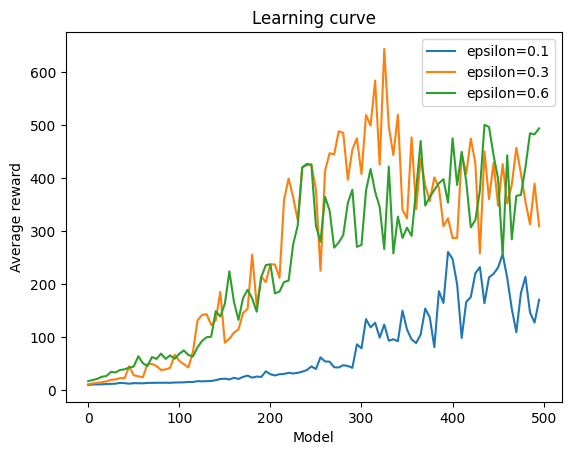

In [119]:
import matplotlib.pyplot as plt


# Create an array for the x-axis values
x_values = 5 * np.arange(len(mean_rewards_01))

plt.plot(x_values, mean_rewards_01, label="epsilon=0.1")
plt.plot(x_values, mean_rewards_03, label="epsilon=0.3")
plt.plot(x_values, mean_rewards_06, label="epsilon=0.6")
plt.xlabel("Model")
plt.ylabel("Average reward")
plt.title("Learning curve")
plt.legend()

plt.show()

As we can see, even averaging for 10 runs, there are strong fluctuations in the score. This is about the model learning temporarily causing a decrease in performance, because testing for

We find that among the three balanced 0.3 works best for the exploration probability.

In [129]:
env = gym.make("CartPole-v1")
q_table300= q_learning_continuous(env, state_space_bins, episode_count=300, epsilon=0.3)

env = gym.make("CartPole-v1", render_mode = 'human')
showcase_model_continuous(env, q_table300, state_space_bins, limit=600)

If we just run this code a few times, we can see that different runs can have quite different results. This could be solved by running the algorithm multiple times and picking the best performing model.

What if we mixed the opportunities?

Switched-up epsilon value models performance:

In [57]:
env = gym.make("CartPole-v1")

mean_rewards_03_06 =[]; mean_rewards_06_03 =[]
for i in range(20):
    rewards_03_1, q_model_03_1 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=50, epsilon=0.3, )
    rewards_03_1_06_2 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=50, epsilon=0.6, q_table=q_model_03_1)[0]
    rewards_06_1, q_model_06_1 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=50, epsilon=0.6, )
    rewards_06_1_03_2 = learning_curve_continuous(env, state_space_bins, episode_per_model=5, evaluation_episodes=100, models=50, epsilon=0.3, q_table=q_model_06_1)[0]
    
    mean_rewards_03_06.append(rewards_03_1+rewards_03_1_06_2)
    mean_rewards_06_03.append(rewards_06_1+ rewards_06_1_03_2)

mean_rewards_03_06 = np.mean(mean_rewards_03_06, axis=0); mean_rewards_06_03 = np.mean(mean_rewards_06_03, axis=0)

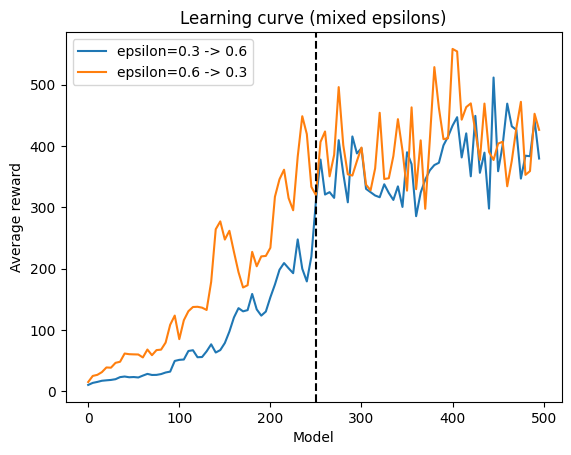

In [58]:
import matplotlib.pyplot as plt
x_values = 5 * np.arange(100);

plt.plot(x_values, mean_rewards_03_06, label="epsilon=0.3 -> 0.6")
plt.plot(x_values, mean_rewards_06_03, label="epsilon=0.6 -> 0.3")
plt.xlabel("Model")
plt.ylabel("Average reward")
plt.title("Learning curve (mixed epsilons)")
plt.axvline(x=250, color='k', linestyle='--')
plt.legend()
plt.show()